In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

df=pd.read_csv('./performance_final.csv')
origin=pd.read_csv('./Wimbledon_featured_matches.csv')
mark=pd.read_csv('./mark.csv')
mark=mark.drop(columns=['Unnamed: 0'])

df = df[df.apply(lambda row: '?' not in row.values, axis=1)]
df = df.reset_index(drop=True)
df=df.drop(columns=['Unnamed: 0'])
df = pd.merge(origin, df, left_index=True, right_index=True)
df = pd.merge(df, mark, left_index=True, right_index=True)

scaler = MinMaxScaler()
df[['mark_1','mark_2']]=(scaler.fit_transform(df[['mark_1','mark_2']]))
columns_to_convert = ['p1_current', 'p2_current', 'p1_overall', 'p2_overall']
df[columns_to_convert] = df[columns_to_convert].apply(pd.to_numeric, errors='coerce')
df.head(2)


,match_id,player1,player2,elapsed_time,set_no,game_no,point_no,p1_sets,p2_sets,p1_games,...,speed_mph,serve_width,serve_depth,return_depth,p1_current,p2_current,p1_overall,p2_overall,mark_1,mark_2
0,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:00:00,1,1,1,0,0,0,...,95.0,BC,NCTL,ND,0.018302,1.047491,0.018302,1.047491,0.027864,0.019417
1,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:00:38,1,1,2,0,0,0,...,118.0,B,CTL,ND,0.317735,0.513602,0.322399,0.780529,0.027864,0.086306


In [107]:
df['mark_1'].tail()
# mark

7279    0.176987
7280    0.253714
7281    0.340737
7282    0.262784
7283    0.349807
Name: mark_1, dtype: float64

In [108]:
mean_mark=(np.mean(df['mark_1'])+np.mean(df['mark_2']))/2
mean_perf=(np.mean(df['p1_current'])+np.mean(df['p2_current']))/2


In [109]:
def mom_reg_adj(mom,mean_0_1):
    d=np.sign(mom-mean_0_1)
    return mean_0_1+d*(1-np.e**(-(np.abs(mom-mean_0_1))))
mom_reg_adj(np.array([0.5,0.9,0,1]), np.array([0.5,0.5,0.2,0.9]))

array([0.5       , 0.82967995, 0.01873075, 0.99516258])

In [110]:
import numpy as np

def gaussian_distribution_value_at_x(x):
    mean = 0
    std_dev = 1
    # 计算正态分布在 x 处的值
    pdf_value = (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mean) / std_dev)**2)
    return pdf_value

def normalize(arr):
    return arr/np.sum(arr)

def get_weight(length_):
    temp=[]
    for i in range(length_):
        temp.append(gaussian_distribution_value_at_x(i*0.5))
    temp=np.sort(np.array(temp))
    return normalize(temp)

def new_game_weight():
    return np.array([0.2,0.8])

def firstgame_momentum():
    return np.array([0.5])


In [111]:
def mom_reg(mom):
    d=np.sign(mom-0.5)
    return 0.5+d*(1-np.e**(-(np.abs(mom-0.5))))

    

def game_mom_cal(df_sub,mom): # df_sub就是3列df
    # column_sub=['performance']#,'score','ph']
    acc_peformance_1=[]
    acc_peformance_2=[]
    acc_score_1=[]
    acc_score_2=[]

    #acc_ph=[]
    # 第一维
    acc_peformance_1.append(mom[0])
    acc_peformance_2.append(mom[1])
    acc_score_1.append(mom[2])
    acc_score_2.append(mom[3])
    #acc_ph.append(mom[2])
    # print(len(df_sub))
    for i in range(len(df_sub)-1):
        weight=get_weight(i+2)
        # print('start_')

        # print(mom)
        # print(np.array(df_sub.iloc[:i+1]))
        # print(weight)
        # print('___')
        mom=np.dot(weight,np.vstack((mom, np.array(df_sub.iloc[:i+1]))))
        # print(weight.shape,mom.shape, np.array(df_sub.iloc[:i+1]).shape)
        acc_peformance_1.append(mom[0])
        acc_peformance_2.append(mom[1])
        acc_score_1.append(mom[2])
        acc_score_2.append(mom[3])
        # print(len(acc_peformance_2),len(acc_score_1))
    # print(mom)

    #这里可能有点问题
    weight=get_weight(len(df_sub)+1)
    mom=np.dot(weight,np.vstack((mom, np.array(df_sub.iloc[:]))))
    mom=mom_reg_adj(mom=mom,mean_0_1=[mean_perf,mean_perf,mean_mark,mean_mark])
    return mom, acc_peformance_1,acc_peformance_2, acc_score_1,acc_score_2  

In [112]:
# temp_df_player_2
mean_perf

0.5133983805304014

In [113]:
# 遍历全体数据集
game_temp_df=[]
all_col=['match_id','set_no','game_no','p1_current','p2_current','mark_1','mark_2']
result=pd.DataFrame(columns=['p1_current','p2_current','mark_1','mark_2'])
for i in df['match_id'].unique():  #在一个大比赛里面 ['2023-wimbledon-1301']:
    print(i)
    #momentom初始化
    mom=np.array([mean_perf,mean_perf,mean_mark,mean_mark])


    temp_df_player_1=df[(df['match_id']==i)][all_col]  #已知是在同一局游戏里面 随便加
    for k in temp_df_player_1['set_no'].unique():
        temp_df_player_2=temp_df_player_1[(temp_df_player_1['set_no']==k)][all_col]

        for j in temp_df_player_2['game_no'].unique():
            game_temp_df=pd.DataFrame(columns=['p1_current','p2_current','mark_1','mark_2'])
            temp_df_player_3=temp_df_player_2[(temp_df_player_2['game_no']==j)][all_col]
            # print(j)
            mom, game_temp_df['p1_current'],game_temp_df['p2_current'],game_temp_df['mark_1'],game_temp_df['mark_2']=game_mom_cal(temp_df_player_3[['p1_current','p2_current','mark_1','mark_2']],mom=mom)
            result=pd.concat([result, game_temp_df], ignore_index=True)
result

    

2023-wimbledon-1301
2023-wimbledon-1302
2023-wimbledon-1303
2023-wimbledon-1304
2023-wimbledon-1305
2023-wimbledon-1306
2023-wimbledon-1307
2023-wimbledon-1308
2023-wimbledon-1309
2023-wimbledon-1310
2023-wimbledon-1311
2023-wimbledon-1312
2023-wimbledon-1313
2023-wimbledon-1314
2023-wimbledon-1315
2023-wimbledon-1316
2023-wimbledon-1401
2023-wimbledon-1402
2023-wimbledon-1403
2023-wimbledon-1404
2023-wimbledon-1405
2023-wimbledon-1406
2023-wimbledon-1407
2023-wimbledon-1408
2023-wimbledon-1501
2023-wimbledon-1502
2023-wimbledon-1503
2023-wimbledon-1504
2023-wimbledon-1601
2023-wimbledon-1602
2023-wimbledon-1701


,p1_current,p2_current,mark_1,mark_2
0,0.513398,0.513398,0.183289,0.183289
1,0.250398,0.797114,0.100726,0.096239
2,0.195161,0.771982,0.045619,0.065010
3,0.202652,0.666627,0.050822,0.062991
4,0.293510,0.539416,0.061070,0.090975
...,...,...,...,...
7279,0.453210,0.586081,0.184367,0.257545
7280,0.416586,0.494091,0.178785,0.231021
7281,0.434304,0.421479,0.204464,0.223559
7282,0.521949,0.438231,0.256736,0.221377


## LR:

In [114]:
result['victor']=df['point_victor']
result['match_id']=df['match_id']
# result
p1_victor = [1 if i == 1 else 0 for i in df['point_victor']]
p2_victor = [1 if i == 2 else 0 for i in df['point_victor']]
result['p1_victor']=p1_victor
result['p2_victor']=p2_victor
result.to_csv('./momentum_factor.csv')
temp_1=result[['match_id','p1_current','mark_1','p1_victor']]
temp_2=result[['match_id','p2_current','mark_2','p2_victor']]

column_mapping = dict(zip(temp_2.columns, temp_1.columns))
temp_2 = temp_2.rename(columns=column_mapping)

df_player12 = temp_1.append(temp_2, ignore_index=True)
df_player12

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24904\2136614413.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_player12 = temp_1.append(temp_2, ignore_index=True)


,match_id,p1_current,mark_1,p1_victor
0,2023-wimbledon-1301,0.513398,0.183289,0
1,2023-wimbledon-1301,0.250398,0.100726,1
2,2023-wimbledon-1301,0.195161,0.045619,0
3,2023-wimbledon-1301,0.202652,0.050822,1
4,2023-wimbledon-1301,0.293510,0.061070,1
...,...,...,...,...
14563,2023-wimbledon-1701,0.586081,0.257545,0
14564,2023-wimbledon-1701,0.494091,0.231021,0
14565,2023-wimbledon-1701,0.421479,0.223559,1
14566,2023-wimbledon-1701,0.438231,0.221377,0


In [97]:
temp=result[['p1_current','p2_current','mark_1','mark_2','victor']].iloc[:-1].reset_index(drop=True)
temp['victor']=result['victor'].iloc[1:].reset_index(drop=True)
temp['match_id']=df['match_id']


In [115]:
result


,p1_current,p2_current,mark_1,mark_2,victor,match_id,p1_victor,p2_victor
0,0.513398,0.513398,0.183289,0.183289,2,2023-wimbledon-1301,0,1
1,0.250398,0.797114,0.100726,0.096239,1,2023-wimbledon-1301,1,0
2,0.195161,0.771982,0.045619,0.065010,2,2023-wimbledon-1301,0,1
3,0.202652,0.666627,0.050822,0.062991,1,2023-wimbledon-1301,1,0
4,0.293510,0.539416,0.061070,0.090975,1,2023-wimbledon-1301,1,0
...,...,...,...,...,...,...,...,...
7279,0.453210,0.586081,0.184367,0.257545,1,2023-wimbledon-1701,1,0
7280,0.416586,0.494091,0.178785,0.231021,1,2023-wimbledon-1701,1,0
7281,0.434304,0.421479,0.204464,0.223559,2,2023-wimbledon-1701,0,1
7282,0.521949,0.438231,0.256736,0.221377,1,2023-wimbledon-1701,1,0


In [98]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# df=pd.read_csv('./player_12_1.csv')

# df['p1_sets'].unique()

# 假设df是你的DataFrame
# X是前9列特征，y是最后一列目标
used_columns=temp.columns[:2]
X = temp[used_columns]
y = temp['victor']

condition_left = (temp['match_id'] != '2023-wimbledon-1301')
condition_in = (temp['match_id'] == '2023-wimbledon-1301')

remaining_rows = X.iloc[np.array(temp[condition_left].index)]
# 将数据划分为训练集和测试集
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train=X.iloc[np.array(temp[condition_left].index)]
X_test=X.iloc[np.array(temp[condition_in].index)]

y_train=y.iloc[np.array(temp[condition_left].index)]
y_test=y.iloc[np.array(temp[condition_in].index)]

# 创建并训练逻辑回归模型
logistic_regression = LogisticRegression(random_state=42)
logistic_regression.fit(X_train, y_train)

# 在测试集上进行预测和获取概率
y_pred = logistic_regression.predict(X_test)
class_probabilities = logistic_regression.predict_proba(X_test)

# 输出模型评估指标
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(classification_report_output)
print(logistic_regression.coef_)


# 输出逻辑回归的概率
# for i in range(len(X_test)):
#     print(f"True Label: {y_test.iloc[i]}, Predicted Label: {y_pred[i]}, Class Probabilities: {class_probabilities[i]}")
#     print(X_test.iloc[i])

Accuracy: 0.5200
Classification Report:
              precision    recall  f1-score   support

           1       0.54      0.58      0.56       159
           2       0.49      0.45      0.47       141

    accuracy                           0.52       300
   macro avg       0.52      0.52      0.52       300
weighted avg       0.52      0.52      0.52       300

[[ 0.71999912 -0.78545279]]


In [100]:
temp.iloc[:30]

,p1_current,p2_current,mark_1,mark_2,victor,match_id
0,0.513398,0.513398,0.183289,0.183289,1,2023-wimbledon-1301
1,0.250398,0.797114,0.100726,0.096239,2,2023-wimbledon-1301
2,0.195161,0.771982,0.045619,0.065010,1,2023-wimbledon-1301
3,0.202652,0.666627,0.050822,0.062991,1,2023-wimbledon-1301
4,0.293510,0.539416,0.061070,0.090975,2,2023-wimbledon-1301
5,0.375377,0.455836,0.088633,0.106029,1,2023-wimbledon-1301
6,0.492800,0.401489,0.134808,0.113684,2,2023-wimbledon-1301
7,0.578199,0.433857,0.152774,0.142690,1,2023-wimbledon-1301
8,0.615856,0.529025,0.184038,0.156440,1,2023-wimbledon-1301
9,0.642954,0.616623,0.181423,0.163495,2,2023-wimbledon-1301


In [82]:
result['victor'][1:]

1       1
2       2
3       1
4       1
5       2
       ..
7279    1
7280    1
7281    2
7282    1
7283    1
Name: victor, Length: 7283, dtype: int64

In [101]:
result[['p1','p2']]=df[['p1_current','p2_current']]

In [102]:
result.iloc[:30]

,p1_current,p2_current,mark_1,mark_2,victor,p1_victor,p2_victor,match_id,p1,p2
0,0.513398,0.513398,0.183289,0.183289,2,0,1,2023-wimbledon-1301,0.018302,1.047491
1,0.250398,0.797114,0.100726,0.096239,1,1,0,2023-wimbledon-1301,0.317735,0.513602
2,0.195161,0.771982,0.045619,0.065010,2,0,1,2023-wimbledon-1301,0.215337,0.536462
3,0.202652,0.666627,0.050822,0.062991,1,1,0,2023-wimbledon-1301,0.449447,0.375516
4,0.293510,0.539416,0.061070,0.090975,1,1,0,2023-wimbledon-1301,0.477716,0.375319
5,0.375377,0.455836,0.088633,0.106029,2,0,1,2023-wimbledon-1301,0.668329,0.352357
6,0.492800,0.401489,0.134808,0.113684,1,1,0,2023-wimbledon-1301,0.668365,0.536091
7,0.578199,0.433857,0.152774,0.142690,2,0,1,2023-wimbledon-1301,0.627290,0.699362
8,0.615856,0.529025,0.184038,0.156440,1,1,0,2023-wimbledon-1301,0.669663,0.722471
9,0.642954,0.616623,0.181423,0.163495,1,1,0,2023-wimbledon-1301,0.629657,0.700299


In [105]:
mark[['p1','p2']]=df[['p1_victor','p2_victor']]
mark.iloc[:10]

,mark_1,mark_2,p1,p2
0,20.952381,20.952381,0,1
1,20.952381,34.666667,1,0
2,34.666667,30.952381,0,1
3,30.952381,45.866667,1,0
4,45.866667,40.952381,1,0
5,63.180952,40.952381,0,1
6,50.952381,57.066667,1,0
7,68.266667,50.952381,0,1
8,50.952381,50.952381,1,0
9,68.266667,50.952381,1,0


In [118]:
mark

,mark_1,mark_2
0,20.952381,20.952381
1,20.952381,34.666667
2,34.666667,30.952381
3,30.952381,45.866667
4,45.866667,40.952381
...,...,...
7279,55.714286,68.800000
7280,73.600000,61.428571
7281,93.885714,61.428571
7282,75.714286,80.000000


In [119]:
result

,p1_current,p2_current,mark_1,mark_2,victor,match_id,p1_victor,p2_victor
0,0.513398,0.513398,0.183289,0.183289,2,2023-wimbledon-1301,0,1
1,0.250398,0.797114,0.100726,0.096239,1,2023-wimbledon-1301,1,0
2,0.195161,0.771982,0.045619,0.065010,2,2023-wimbledon-1301,0,1
3,0.202652,0.666627,0.050822,0.062991,1,2023-wimbledon-1301,1,0
4,0.293510,0.539416,0.061070,0.090975,1,2023-wimbledon-1301,1,0
...,...,...,...,...,...,...,...,...
7279,0.453210,0.586081,0.184367,0.257545,1,2023-wimbledon-1701,1,0
7280,0.416586,0.494091,0.178785,0.231021,1,2023-wimbledon-1701,1,0
7281,0.434304,0.421479,0.204464,0.223559,2,2023-wimbledon-1701,0,1
7282,0.521949,0.438231,0.256736,0.221377,1,2023-wimbledon-1701,1,0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 生成示例数据
p1_overall_per=[]
p2_overall_per=[]
temp_1=result['performance'][index]
temp_2=player2['performance'][index]

p1_overall_per.append(temp_1[index[0]])
p2_overall_per.append(temp_2[index[0]])
    
for i in range(len(temp_1)-1):
    p1_overall_per.append((temp_1[index[i+1]]/(maximum_pt*(i+2))
                           +p1_overall_per[-1]*((i+1)/(i+2))))
    p2_overall_per.append((temp_2[index[i+1]]/(maximum_pt*(i+2))
                           +p2_overall_per[-1]*((i+1)/(i+2))))

# 获取数组长度
x = np.arange(len(index))

# 绘制折线图
plt.figure(figsize=(15,5))
plt.plot(x[5:], np.array(p1_overall_per)[5:], marker='o', linestyle='-', color='b', label='Carlos Alcaraz')
plt.plot(x[5:], np.array(p2_overall_per)[5:], marker='o', linestyle='-', color='r', label='Nicolas Jarry')

# 添加标签和标题
plt.xlabel('turns')
plt.ylabel('performance points')
plt.title('overall performance of players')

# 添加图例
plt.legend()

# 显示图形
plt.show()

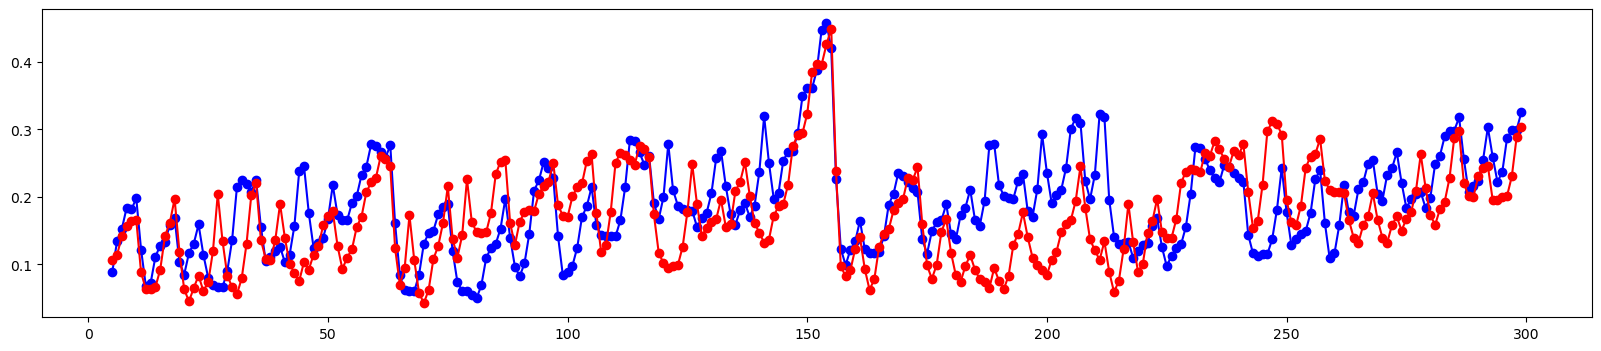

In [144]:
# temp_1=p1_current_per+player1['p1_victor']*0.2
# temp_2=p2_current_per+player2['p1_victor']*0.2

x = np.arange(len(temp_1))
temp_1=result['mark_1']
temp_2=df["p1_current"]

temp_3=result['mark_2']
temp_4=df["p2_current"]
c=0
plt.figure(figsize=(20,4))
plt.plot(x[5:300], temp_1[5:300]+c*temp_2[5:300], marker='o', linestyle='-', color='b', label='Carlos Alcaraz')
plt.plot(x[5:300], temp_3[5:300]+c*temp_4[5:300],marker='o', linestyle='-', color='r', label='Nicolas Jarry')
p1_performance_plus=temp_1
p2_performance_plus=temp_2



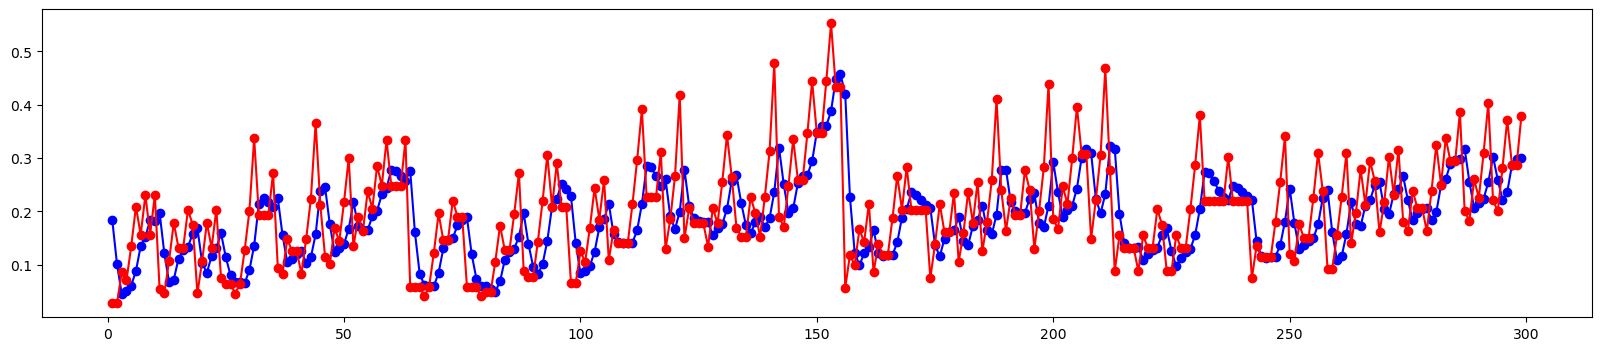

In [130]:
x = np.arange(len(temp_1))
temp_1=result['mark_1']
temp_2=df["mark_1"]

temp_3=result['mark_2']
temp_4=df["p2_current"]

plt.figure(figsize=(20,4))
plt.plot(x[1:300], temp_1[0:299], marker='o', linestyle='-', color='b', label='Carlos Alcaraz')
plt.plot(x[1:300], temp_2[0:299],marker='o', linestyle='-', color='r', label='Nicolas Jarry')

p1_performance_plus=temp_1
p2_performance_plus=temp_2
